### Import libraries

In [61]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, shuffle
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

print(tf.config.list_physical_devices())

import shutil
from IPython.display import FileLink


2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set seed for reproducibility

In [62]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Hyper parameters for augmentation, splines interpolation and scaling

In [63]:
scaling = True # applies standard scaling to the data
apply_oversampling = False # introduces white noise to the oversampled data

use_splines_resolution = False # uses splines for cubic interpolation the data
use_splines_augmentation = True # uses splines for cubic interpolation to create more artificial samples

 ## Load the training dataset

In [64]:
path = "/kaggle/input/competition2/"
# Load the .npy file
X = np.load(path + "x_train.npy")
y = np.load(path + "y_train.npy")

# Convert to float32 for less precision and better performance
X = X.astype(np.float32)
y = y.astype(np.int32)

# shuffle X, y
X, y = shuffle(X, y, random_state=seed)

print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float32
(2429,), int32


Training - Validation Split

In [65]:

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)
print("training set : ", X_train.shape)
print("test set: ", X_test.shape)

training set :  (1943, 36, 6)
test set:  (486, 36, 6)


Plotting the classes distributions

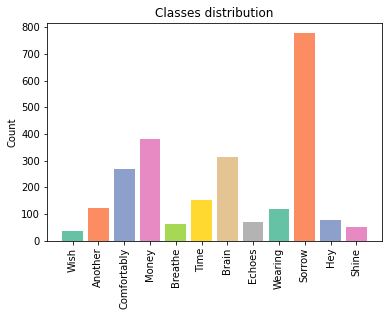

In [66]:
# Map classes STRINGS to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

#vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


Class weights computation

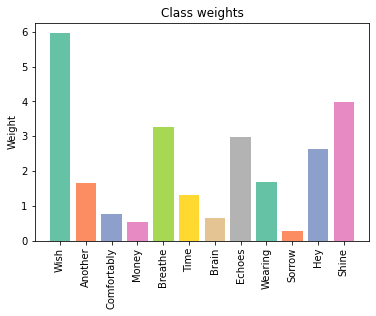

In [67]:
# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y)))

# plot class weights with respect to the labels
plt.title('Class weights')
plt.bar(label_mapping.keys(), class_weights.values(), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.show()


## Data preprocessing with cubic interpolation between data points for increasing resolution

Before the cubic spline interpolation 

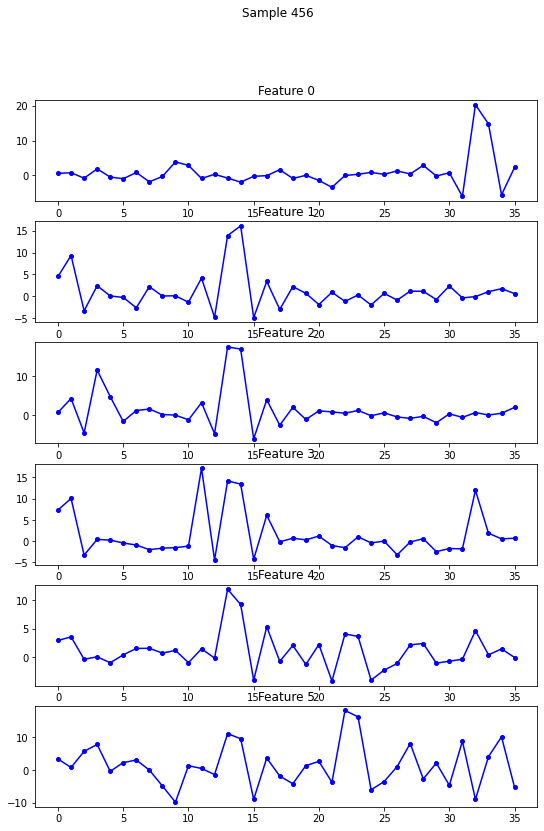

In [68]:
# plot the sequence of points in a randomly drawn sample from X
sample = random.randint(0, X.shape[0])

# create a figure with 6 subplots, one plot per each feature
fig, axs = plt.subplots(6, 1, figsize=(9, 13))
fig.suptitle('Sample ' + str(sample))
for i in range(6):
	axs[i].set_title('Feature ' + str(i))
	# add a dot at each point in the sequence
	axs[i].plot(X[sample, :, i], 'o-', color='blue', markersize=4)

plt.show()


Application of spline interpolation to create a spline with new points

In [69]:
# add cubic spline interpolation between the data points of the sequence X[sample, :, i] and return the new set of points

from scipy import interpolate

interpolation_multiplier = 3 # resolution multiplier

# triple the number of points in the sequence to increase the resolution by a factor of 3
x_lin = np.linspace(0, 35, 36 * interpolation_multiplier)

# new augmented dataset
X_spline = np.zeros((X.shape[0], x_lin.size, 6))
print(X_spline.shape)

for i in np.arange(X[:, 0, 0].size): # for each sample
	for j in np.arange(6): # for each feature
		# add a cubic spline interpolation between the data points of X[sample, :, 0]
		interpolation = interpolate.interp1d(np.arange(0, 36), X[i, :, j], kind='cubic', fill_value="extrapolate")
		X_spline[i, :, j] = interpolation(x_lin)


(2429, 108, 6)


Plot the new sequence of interpolated points

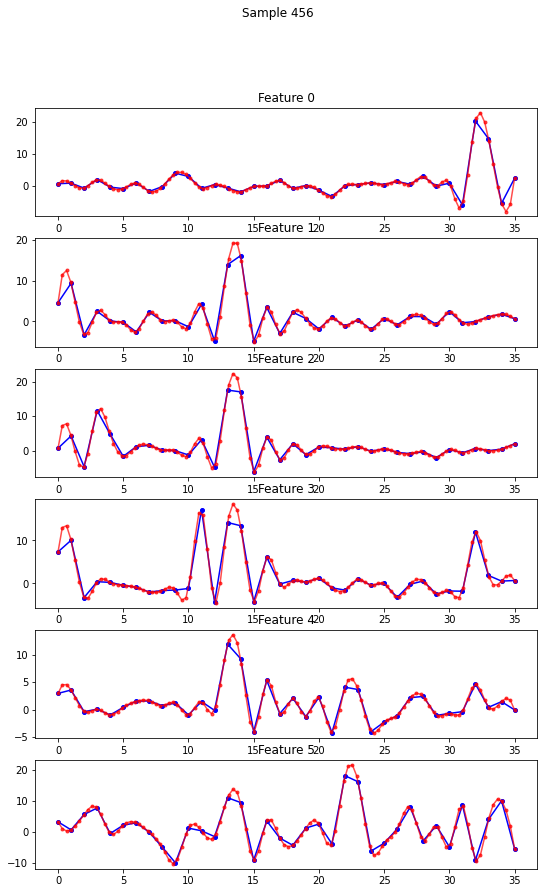

In [70]:
# create a figure with 6 subplots, one plot per each feature
fig, axs = plt.subplots(6, 1, figsize=(9, 14))
fig.suptitle('Sample ' + str(sample))
for i in range(6):
	axs[i].set_title('Feature ' + str(i))
	# plots the given sequence of points without interpolation
	axs[i].plot(np.arange(0, 36), X[sample, :, i], 'o-', color='blue', markersize=4)

	# plots the new set of points with cubic spline interpolation
	axs[i].plot(x_lin, X_spline[sample, :, i], "o-", color='red', markersize = 3, alpha = 0.7)

plt.show()

Applies splines interpolation to the dataset

In [71]:

# when using splines, it's better to have a bigger filter size in the convolutional layers
if (use_splines_resolution):
    X = X_spline


## Offline data oversampling 

Oversampling the classes in a manner proportional to the class weights

In [72]:
# for each class take the samples and copy them in a new array
X_oversampled = np.empty((0, X_train.shape[1], X_train.shape[2]), dtype=np.float32)
y_oversampled = np.empty((0,), dtype=np.int32)

# compute the increment multiplier for each class based on its class weight
increment = np.zeros(len(label_mapping), dtype=np.int32)
for i in range(len(label_mapping)):
	increment[i] = int(np.ceil(np.max(np.bincount(y)) / np.bincount(y)[i]))

print("increment multiplier = ", increment)

# for each sample in the original dataset, copy it in the new array as many times as its class increment multiplier
for i in range(len(y_train)):

	# each sample is copied increment[y[i]] times in the new array
	for j in range(increment[y_train[i]]):
		X_oversampled = np.append(X_oversampled, np.expand_dims(X_train[i], axis=0), axis=0)
		y_oversampled = np.append(y_oversampled, np.expand_dims(y_train[i], axis=0), axis=0)

		# compute min and max for each X[i, :, k]
		for k in range(X.shape[2]):
			mins = np.min(X_train[i, :, k], axis=0)
			maxs = np.max(X_train[i, :, k], axis=0)

			# then add random gaussian noise to each sample
			values = np.random.normal(0, 0.05 * (maxs - mins), X_train.shape[1])
			X_oversampled[i, :, k] = np.add(X_oversampled[i, :, k], values)


print("new oversampled dataset size ", X_oversampled.shape, y_oversampled.shape, sep=", ")

# shuffle the data
X_oversampled, y_oversampled = shuffle(X_oversampled, y_oversampled, random_state=seed)


increment multiplier =  [23  7  3  3 13  6  3 12  7  1 11 16]
new oversampled dataset size , (8253, 36, 6), (8253,)


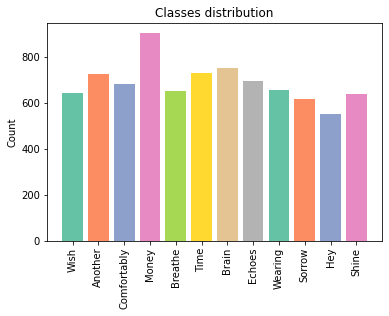

In [73]:

# plot the new distribution of the classes
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y_oversampled), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()


New class weights after the oversampling

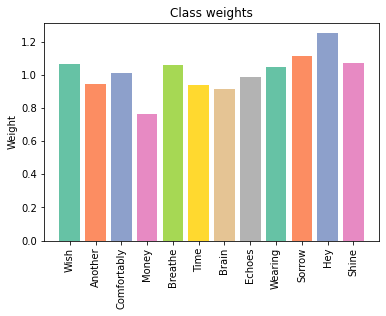

In [74]:
# compute and plot the new class weights
labels = np.unique(np.fromiter([t for t in y_oversampled], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_oversampled)))

plt.title('Class weights')
plt.bar(label_mapping.keys(), class_weights.values(), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.show()


Save the oversampled dataset

In [75]:
if (apply_oversampling):
	# save augmented dataset in the same dataset
	X_train = X_oversampled
	y_train = y_oversampled


## Offline augmentation with cubic interpolation using splines to create new artificial samples of the original length

In [76]:
# create a new augmented dataset with the new samples that is as big as the original training dataset
X_augmented = np.empty((0, X_train.shape[1], X_train.shape[2]), dtype=np.float32)
y_augmented = np.empty((0,), dtype=np.int32)

print("interpolation_multiplier = ", interpolation_multiplier)

# for each sample in the training dataset
for i in range(y_train.shape[0]):

	# copy the original sample in the augmented dataset every 3 points from X_spline[i, k, :]
	for j in range(interpolation_multiplier):
		X_augmented = np.append(X_augmented, np.expand_dims(X_spline[i, j::interpolation_multiplier, :], axis=0), axis=0)
		y_augmented = np.append(y_augmented, np.expand_dims(y_train[i], axis=0), axis=0)

		# for each sample, add a random gaussian noise to each feature
	
		for k in range(X_augmented.shape[2]):
			mins = np.min(X_augmented[-1, :, k], axis=0)
			maxs = np.max(X_augmented[-1, :, k], axis=0)

			values = np.random.normal(0, 0.05 * (maxs - mins), X_augmented.shape[1])
			X_augmented[-1, :, k] = np.add(X_augmented[-1, :, k], values)

print("new augmented dataset size ", X_augmented.shape, y_augmented.shape, sep=", ")

# shuffle the data
X_augmented, y_augmented = shuffle(X_augmented, y_augmented, random_state=seed)

interpolation_multiplier =  3
new augmented dataset size , (5829, 36, 6), (5829,)


In [77]:
if (use_splines_augmentation):
	X_train = X_augmented
	y_train = y_augmented

## Application of Standard Scaler to the dataset

In [78]:
features_num = X_train.shape[2]
print("features: ", features_num)

from sklearn.preprocessing import StandardScaler

scaler_std = StandardScaler()
# if the standard scaling is requested, computes it on the training set and prints its values
if (scaling):
    num_instances, num_time_steps, num_features = X_train.shape
    X_train = np.reshape(X_train, newshape=(-1, num_features))
    X_train = scaler_std.fit_transform(X_train)

    X_train = np.reshape(X_train, newshape=(num_instances, num_time_steps, num_features))

    num_instances, num_time_steps, num_features = X_test.shape
    X_test = np.reshape(X_test, newshape=(-1, num_features))
    X_test = scaler_std.transform(X_test)

    X_test = np.reshape(X_test, newshape=(num_instances, num_time_steps, num_features))
    
    # print the scaling parameters of scaler_std
    print("scaler_std.mean_ = ", scaler_std.mean_)
    print("scaler_std.var_ = ", scaler_std.var_)
    print("scaler_std.scale_ = ", scaler_std.scale_)
    print("scaler_std.n_samples_seen_ = ", scaler_std.n_samples_seen_)
    print("scaler_std.n_features_in_ = ", scaler_std.n_features_in_)


features:  6
scaler_std.mean_ =  [ 7.0979123  17.56996092 26.85087137 33.05342971 34.86019137 32.12504973]
scaler_std.var_ =  [ 53093.2062708  623528.20452426 513543.66902708 512535.40484842
 515963.23601382 619725.97718494]
scaler_std.scale_ =  [230.41963083 789.6380212  716.61961251 715.91578056 718.30580954
 787.22676351]
scaler_std.n_samples_seen_ =  209844
scaler_std.n_features_in_ =  6


Categorical labels for the training and test data

In [79]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(X_train.shape, y_train.shape, sep=", ")
print(X_test.shape, y_test.shape, sep=", ")

(5829, 36, 6), (5829, 12)
(486, 36, 6), (486, 12)


## Build the models

Hyperparameters

In [80]:
input_shape = X_train.shape[1:]
print("input shape: ", input_shape)
classes = y_train.shape[-1]
batch_size = 128
epochs = 800


input shape:  (36, 6)


Plot history of the training and the learning rate schedule

In [81]:
def plot_history(history):
	best_epoch = np.argmax(history['val_accuracy'])
	plt.figure(figsize=(17,4))
	plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Categorical Crossentropy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
	plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.title('Accuracy')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

	plt.figure(figsize=(17,4))
	plt.title('Learning Rate Schedule')
	plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
	plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
	plt.legend()
	plt.grid(alpha=.3)
	plt.show()

Plot confusion matrix, F1 scores and displays model accuracy

In [82]:
def plot_statistics(predictions):	
	# Compute the confusion matrix
	cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

	# Compute the classification metrics
	accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
	precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
	print('Accuracy:',accuracy.round(4))
	print('Precision:',precision.round(4))
	print('Recall:',recall.round(4))
	print('F1:',f1.round(4))

	# Plot the confusion matrix
	plt.figure(figsize=(7, 6))
	plt.title('Confusion matrix')
	sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
	plt.xlabel('True labels')
	plt.ylabel('Predicted labels')
	plt.show()

	# horizontal bar plot of the f1 scores for each class
	plt.figure(figsize=(6,4))
	plt.grid(alpha=.3)
	plt.barh(y=list(label_mapping.keys()), width=f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None))
	plt.title('F1 scores')
	plt.show()

#### Only convolutional and dense layers

In [83]:
def build_conv_dense(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(input_layer)
    
    x = tfkl.MaxPooling1D()(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.MaxPooling1D(name='mp2')(x)

    x = tfkl.Conv1D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.GlobalAveragePooling1D()(x)
    
    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)

    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.Dense(
        units = 128,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    
    x = tfkl.Dropout(0.5, seed=seed)(x)

    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(7e-4), metrics='accuracy')

    # Return the model
    return model

In [84]:
model = build_conv_dense(input_shape)
model.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 36, 256)           4864      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 18, 256)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 18, 256)           196864    
_________________________________________________________________
mp2 (MaxPooling1D)           (None, 9, 256)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 9, 256)            196864    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 256)               0    

In [85]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=40, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=15, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/800
46/46 [==============================] - 1s 14ms/step - loss: 2.3788 - accuracy: 0.2904 - val_loss: 1.9728 - val_accuracy: 0.3992
Epoch 2/800
46/46 [==============================] - 0s 9ms/step - loss: 1.9521 - accuracy: 0.3762 - val_loss: 1.7473 - val_accuracy: 0.4383
Epoch 3/800
46/46 [==============================] - 0s 9ms/step - loss: 1.7925 - accuracy: 0.4160 - val_loss: 1.6466 - val_accuracy: 0.4671
Epoch 4/800
46/46 [==============================] - 0s 7ms/step - loss: 1.6410 - accuracy: 0.4618 - val_loss: 1.4920 - val_accuracy: 0.5165
Epoch 5/800
46/46 [==============================] - 0s 7ms/step - loss: 1.5109 - accuracy: 0.5064 - val_loss: 1.4028 - val_accuracy: 0.5700
Epoch 6/800
46/46 [==============================] - 0s 9ms/step - loss: 1.3799 - accuracy: 0.5419 - val_loss: 1.2182 - val_accuracy: 0.6049
Epoch 7/800
46/46 [==============================] - 0s 9ms/step - loss: 1.2559 - accuracy: 0.5799 - val_loss: 1.0865 - val_accuracy: 0.6296
Epoch 8/800


Convolutional model evaluation

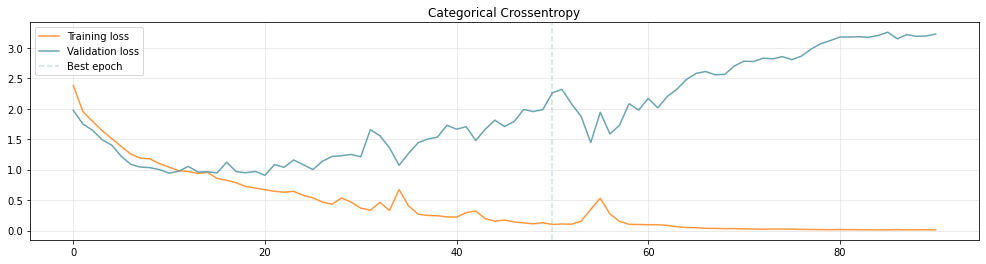

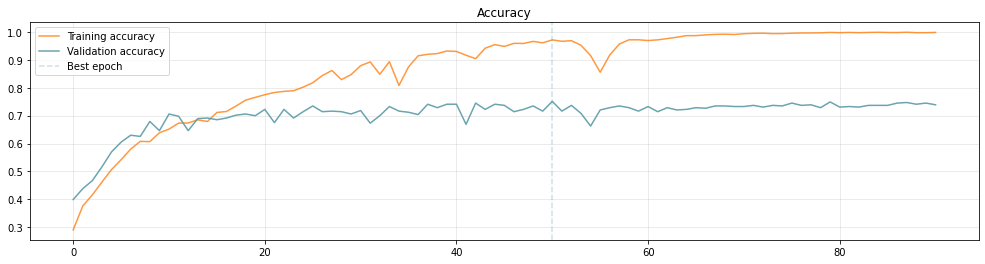

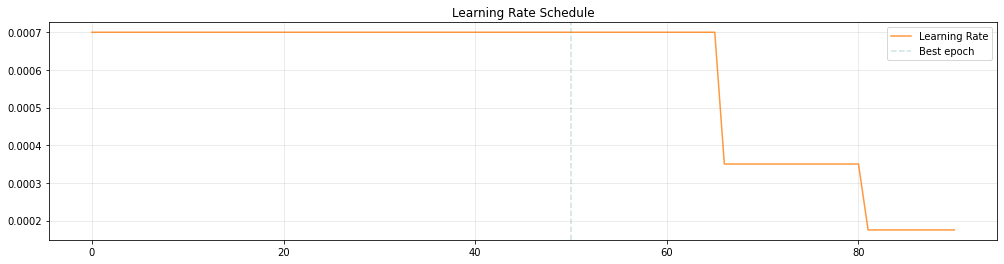

Accuracy: 0.751
Precision: 0.719
Recall: 0.6189
F1: 0.6433


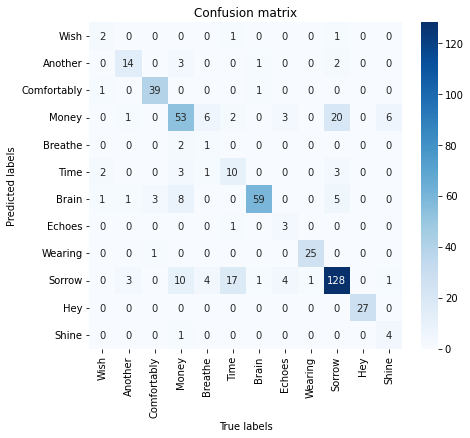

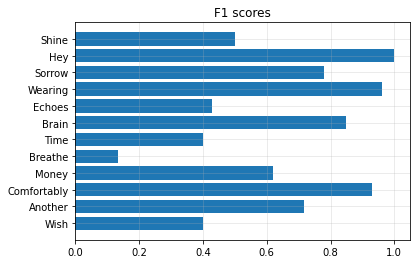

In [86]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)

Save model with the validation accuracy in the name

In [87]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
if (accuracy > 0.75):
    model_name = "model_convdense_" + str(accuracy.round(5))
    model.save(model_name)
    
    shutil.make_archive(model_name, 'zip', model_name)
    FileLink(r"" + model_name + ".zip")

#### Bidirectional Long Short Term Memory (BiLSTM) Neural Network

In [88]:
def build_BiLSTM_classifier(input_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor

    x = tfkl.Conv1D(filters = 128, kernel_size = 7, padding = 'same',
        activation = 'relu', kernel_initializer = tfk.initializers.HeUniform(seed)
        )(input_layer)
    x = tfkl.MaxPooling1D(pool_size = 3)(x)
    x = tfkl.Conv1D(filters = 128, kernel_size = 5, padding = 'same',
        activation = 'relu', kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    x = tfkl.MaxPooling1D(pool_size = 3)(x)
    x = tfkl.Conv1D(filters = 128, kernel_size = 3, padding = 'same',
        activation = 'relu', kernel_initializer = tfk.initializers.HeUniform(seed)
        )(x)
    x = tfkl.GlobalAveragePooling1D()(x)

    x = tfkl.Dropout(.4, seed=seed)(x)

    # Classifier
    x = tfkl.Dense(128, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dense(128, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    x = tfkl.Dense(128, activation='relu', kernel_initializer = tfk.initializers.HeUniform(seed))(x)
    
    x = tfkl.Dropout(.4, seed=seed)(x)
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model2')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(3e-4), metrics='accuracy')

    # Return the model
    return model

In [89]:
model = build_BiLSTM_classifier(input_shape)
model.summary() #note double number of parameters (this is because we have a bidirectional lstm)

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 36, 256)           4864      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 18, 256)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 18, 256)           196864    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 9, 256)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 9, 256)            196864    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 4, 256)            0    

In [90]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    #class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=11, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.75, min_lr=1e-5)
    ]
).history

Epoch 1/800
46/46 [==============================] - 10s 55ms/step - loss: 2.1558 - accuracy: 0.3278 - val_loss: 1.8678 - val_accuracy: 0.3621
Epoch 2/800
46/46 [==============================] - 1s 17ms/step - loss: 1.8762 - accuracy: 0.3843 - val_loss: 1.6720 - val_accuracy: 0.4383
Epoch 3/800
46/46 [==============================] - 1s 18ms/step - loss: 1.7056 - accuracy: 0.4287 - val_loss: 1.4572 - val_accuracy: 0.5144
Epoch 4/800
46/46 [==============================] - 1s 15ms/step - loss: 1.5082 - accuracy: 0.4889 - val_loss: 1.2967 - val_accuracy: 0.5412
Epoch 5/800
46/46 [==============================] - 1s 15ms/step - loss: 1.3734 - accuracy: 0.5359 - val_loss: 1.2968 - val_accuracy: 0.5597
Epoch 6/800
46/46 [==============================] - 1s 15ms/step - loss: 1.2663 - accuracy: 0.5747 - val_loss: 1.0806 - val_accuracy: 0.6564
Epoch 7/800
46/46 [==============================] - 1s 19ms/step - loss: 1.1964 - accuracy: 0.5989 - val_loss: 1.0908 - val_accuracy: 0.6111
Epoch

Bidirectional LSTM model evaluation

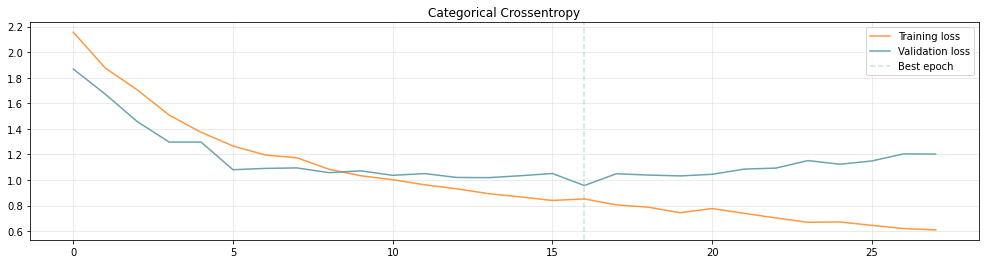

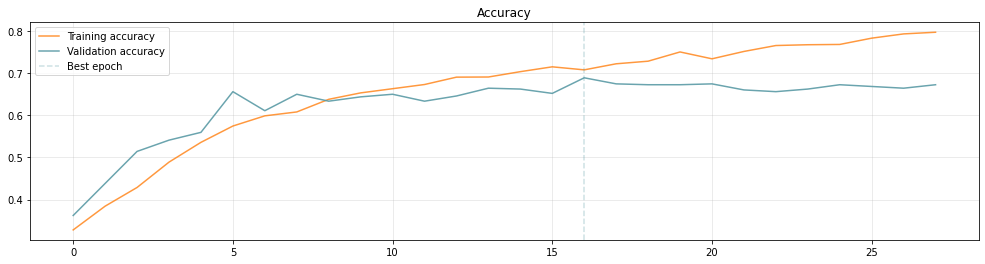

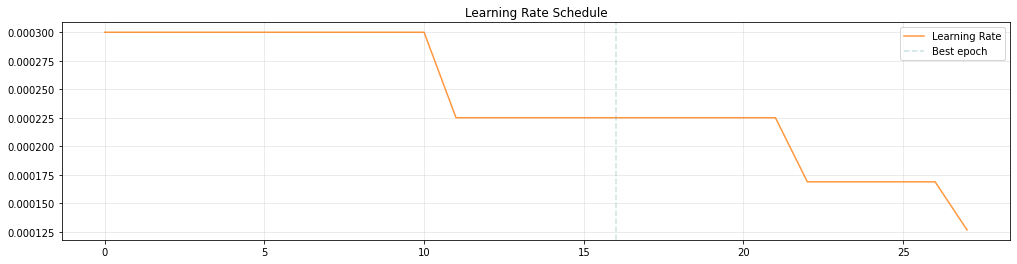

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.6893
Precision: 0.6094
Recall: 0.5298
F1: 0.5456


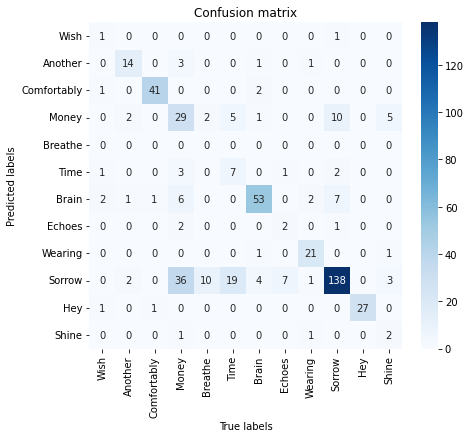

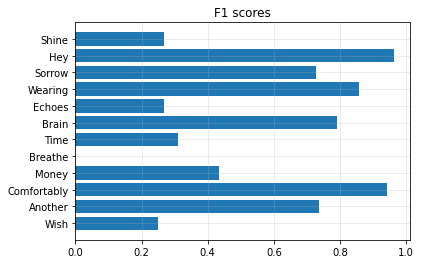

In [91]:
plot_history(history)

# Predict the test set with the LSTM
predictions = model.predict(X_test)

plot_statistics(predictions)

Save bidirectional lstm model with accuracy in the name

In [92]:
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
if (accuracy > 0.71):
    model_name = "model_bilstm_" + str(accuracy.round(5))
    model.save(model_name)
    
    shutil.make_archive(model_name, 'zip', model_name)
    FileLink(r"" + model_name + ".zip")